In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import statsmodels.api as sm
import datetime
import math
from scipy.ndimage.interpolation import shift

warnings.filterwarnings('ignore')
import seaborn as sns
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines

## Load Polygons and plot totals

In [2]:
ac_mcclure = gpd.read_file("/data2/lthapa/ML_daily/August_Complex_2020/August_Complex_2020/VIIRS_perdetect_growthonly_August_2020.shp")
ac_mcclure # TIME IS IN UTC

,Fire_ID,DateTim,Source,FRP,pixels,Grwth_A,wthn_bn,geometry
0,2020_1480,2020-08-17 09:12:00,VIIRS,277.38,37,2052.295068,1,"MULTIPOLYGON (((-122.74983 39.58869, -122.7499..."
1,2020_1480,2020-08-17 10:54:00,VIIRS,1151.72,43,1511.377711,1,"MULTIPOLYGON (((-122.74982 39.59149, -122.7498..."
2,2020_1480,2020-08-18 08:54:00,VIIRS,41.89,12,276.682712,1,"MULTIPOLYGON (((-122.75290 39.59451, -122.7529..."
3,2020_1480,2020-08-18 10:36:00,VIIRS,49.86,14,322.903531,1,"MULTIPOLYGON (((-122.77944 39.69342, -122.7793..."
4,2020_1480,2020-08-18 20:18:00,VIIRS,1490.95,59,1655.623667,1,"MULTIPOLYGON (((-122.74285 39.59824, -122.7428..."
...,...,...,...,...,...,...,...,...
176,2020_1480,2020-10-17 10:12:00,VIIRS,25.62,20,60.205030,1,"MULTIPOLYGON (((-123.42704 40.18691, -123.4271..."
177,2020_1480,2020-10-18 09:54:00,VIIRS,23.79,20,125.654083,1,"MULTIPOLYGON (((-123.08827 39.96052, -123.0882..."
178,2020_1480,2020-10-18 21:18:00,VIIRS,101.12,6,3.594788,1,"MULTIPOLYGON (((-123.09004 40.24408, -123.0900..."
179,2020_1480,2020-10-19 09:36:00,VIIRS,3.44,4,0.000063,1,"POLYGON ((-123.48914 40.28972, -123.48914 40.2..."


In [3]:
# load in the polygons and attributes
fire_polygons = gpd.read_file('august_complex_polygons_only.geojson') #polygons only
fire_attributes = pd.read_csv('august_complex_polygons_attributes.csv') #other fire attributes
fire_attributes['Fire Name'] = fire_attributes['Fire Name'].str.upper() #make all fire names all caps
aug_complex_inds = np.where(fire_attributes['Fire Name']=='AUGUST COMPLEX')[0];
print(type(aug_complex_inds))

ac_thapa_att = fire_attributes.iloc[aug_complex_inds]

datestrings = [ac_thapa_att['Current Day'].iloc[i]+ ' '+\
               str(int(ac_thapa_att['Current Overpass'].iloc[i])).zfill(4) for i in range(len(ac_thapa_att))]

ac_thapa_poly = fire_polygons.iloc[aug_complex_inds]
ac_thapa = gpd.GeoDataFrame(pd.concat([ac_thapa_att, pd.DataFrame({'DateTim':datestrings}), ac_thapa_poly], axis=1))
ac_thapa

<class 'numpy.ndarray'>


,Unnamed: 0,Incident Number,Fire Name,Current Day,Current Overpass,Lat Fire,Lon Fire,Number of VIIRS points,FRP,DateTim,geometry
0,0,11843929.0,AUGUST COMPLEX,2020-08-18,800.0,39.659444,-122.808889,0.0,NaN,2020-08-18 0800,"POLYGON ((-122.76889 39.65944, -122.76908 39.6..."
1,1,11843929.0,AUGUST COMPLEX,2020-08-18,806.0,39.659444,-122.808889,0.0,NaN,2020-08-18 0806,"POLYGON ((-122.76889 39.65944, -122.76908 39.6..."
2,2,11843929.0,AUGUST COMPLEX,2020-08-18,854.0,39.659444,-122.808889,12.0,41.89,2020-08-18 0854,"POLYGON ((-122.74513 39.59618, -122.75537 39.5..."
3,3,11843929.0,AUGUST COMPLEX,2020-08-18,900.0,39.659444,-122.808889,0.0,NaN,2020-08-18 0900,"POLYGON ((-122.74513 39.59618, -122.75537 39.5..."
4,4,11843929.0,AUGUST COMPLEX,2020-08-18,942.0,39.659444,-122.808889,0.0,NaN,2020-08-18 0942,"POLYGON ((-122.74513 39.59618, -122.75537 39.5..."
...,...,...,...,...,...,...,...,...,...,...,...
1334,1334,11843929.0,AUGUST COMPLEX,2020-11-11,1936.0,39.659444,-122.808889,0.0,NaN,2020-11-11 1936,"POLYGON ((-123.08621 40.24213, -123.15018 40.2..."
1335,1335,11843929.0,AUGUST COMPLEX,2020-11-11,2024.0,39.659444,-122.808889,0.0,NaN,2020-11-11 2024,"POLYGON ((-123.08621 40.24213, -123.15018 40.2..."
1336,1336,11843929.0,AUGUST COMPLEX,2020-11-11,2112.0,39.659444,-122.808889,0.0,NaN,2020-11-11 2112,"POLYGON ((-123.08621 40.24213, -123.15018 40.2..."
1337,1337,11843929.0,AUGUST COMPLEX,2020-11-11,2118.0,39.659444,-122.808889,0.0,NaN,2020-11-11 2118,"POLYGON ((-123.08621 40.24213, -123.15018 40.2..."


## Generate Daily Time Series

In [4]:
#average over the overpasses to avoid double counting
days = [ii[0:10] for ii in ac_mcclure['DateTim'].values]
ac_mcclure['Days'] = days
ac_mcclure_daily= ac_mcclure.dissolve(by='Days', aggfunc='max',as_index=False)
ac_mcclure_daily

,Days,geometry,Fire_ID,DateTim,Source,FRP,pixels,Grwth_A,wthn_bn
0,2020-08-17,"MULTIPOLYGON (((-122.74288 39.58689, -122.7429...",2020_1480,2020-08-17 10:54:00,VIIRS,1151.72,43,2052.295068,1
1,2020-08-18,"MULTIPOLYGON (((-122.73942 39.58791, -122.7394...",2020_1480,2020-08-18 22:00:00,VIIRS,1490.95,59,1655.623667,1
2,2020-08-19,"MULTIPOLYGON (((-122.86329 39.45283, -122.8632...",2020_1480,2020-08-19 21:42:00,VIIRS,61554.17,1275,53253.542093,1
3,2020-08-20,"MULTIPOLYGON (((-122.70969 39.52476, -122.7098...",2020_1480,2020-08-20 21:24:00,VIIRS,45349.47,1598,43838.114817,1
4,2020-08-21,"MULTIPOLYGON (((-122.91202 39.51314, -122.9121...",2020_1480,2020-08-21 21:00:00,VIIRS,14808.29,1095,26895.745938,1
...,...,...,...,...,...,...,...,...,...
59,2020-10-16,"MULTIPOLYGON (((-123.24939 39.97622, -123.2494...",2020_1480,2020-10-16 21:54:00,VIIRS,208.01,44,506.807482,1
60,2020-10-17,"MULTIPOLYGON (((-123.42704 40.18691, -123.4271...",2020_1480,2020-10-17 10:12:00,VIIRS,25.62,20,60.205030,1
61,2020-10-18,"MULTIPOLYGON (((-123.08827 39.96052, -123.0882...",2020_1480,2020-10-18 21:18:00,VIIRS,101.12,20,125.654083,1
62,2020-10-19,"POLYGON ((-123.48914 40.28972, -123.48914 40.2...",2020_1480,2020-10-19 09:36:00,VIIRS,3.44,4,0.000063,1


In [5]:
ac_thapa_daily = ac_thapa.dissolve(by='Current Day', aggfunc='max',as_index=False)
ac_thapa_daily

,Current Day,geometry,Unnamed: 0,Incident Number,Fire Name,Current Overpass,Lat Fire,Lon Fire,Number of VIIRS points,FRP,DateTim
0,2020-08-18,"POLYGON ((-122.94223 39.53097, -122.84170 39.6...",15,11843929.0,AUGUST COMPLEX,2200.0,39.659444,-122.808889,61.0,2140.28,2020-08-18 2200
1,2020-08-19,"POLYGON ((-122.86665 39.45204, -122.87710 39.5...",33,11843929.0,AUGUST COMPLEX,2142.0,39.659444,-122.808889,1251.0,61278.83,2020-08-19 2142
2,2020-08-20,"POLYGON ((-122.67443 39.51714, -122.68256 39.5...",47,11843929.0,AUGUST COMPLEX,2212.0,39.659444,-122.808889,1599.0,61865.20,2020-08-20 2212
3,2020-08-21,"POLYGON ((-123.08426 40.11270, -123.08425 40.1...",64,11843929.0,AUGUST COMPLEX,2154.0,39.659444,-122.808889,1095.0,15955.66,2020-08-21 2154
4,2020-08-22,"POLYGON ((-122.92023 39.50605, -122.92345 39.5...",80,11843929.0,AUGUST COMPLEX,2136.0,39.659444,-122.808889,920.0,9421.96,2020-08-22 2136
...,...,...,...,...,...,...,...,...,...,...,...
81,2020-11-07,"POLYGON ((-123.08621 40.24213, -123.15018 40.2...",1276,11843929.0,AUGUST COMPLEX,2142.0,39.659444,-122.808889,0.0,NaN,2020-11-07 2142
82,2020-11-08,"POLYGON ((-123.08621 40.24213, -123.15018 40.2...",1293,11843929.0,AUGUST COMPLEX,2212.0,39.659444,-122.808889,0.0,NaN,2020-11-08 2212
83,2020-11-09,"POLYGON ((-123.08621 40.24213, -123.15018 40.2...",1308,11843929.0,AUGUST COMPLEX,2154.0,39.659444,-122.808889,0.0,NaN,2020-11-09 2154
84,2020-11-10,"POLYGON ((-123.08621 40.24213, -123.15018 40.2...",1323,11843929.0,AUGUST COMPLEX,2136.0,39.659444,-122.808889,0.0,NaN,2020-11-10 2136


In [6]:
#get the days that are covered by both time series (stored in times)
times_mcclure = np.arange(np.datetime64(ac_mcclure_daily['Days'].iloc[0]),\
                          np.datetime64(ac_mcclure_daily['Days'].iloc[len(ac_mcclure_daily)-1])+np.timedelta64(1,'D'))
times_thapa = np.arange(np.datetime64(ac_thapa_daily['Current Day'].iloc[0]),\
                          np.datetime64(ac_thapa_daily['Current Day'].iloc[len(ac_thapa_daily)-1])+np.timedelta64(1,'D'))
times, c1, c2 = np.intersect1d(times_mcclure, times_thapa, return_indices=True)

print(times)

#c1
#The indices of the first occurrences of the common values in times_mcclure. Only provided if return_indices is True.

#c2
#The indices of the first occurrences of the common values in times_thapa. Only provided if return_indices is True.


['2020-08-18' '2020-08-19' '2020-08-20' '2020-08-21' '2020-08-22'
 '2020-08-23' '2020-08-24' '2020-08-25' '2020-08-26' '2020-08-27'
 '2020-08-28' '2020-08-29' '2020-08-30' '2020-08-31' '2020-09-01'
 '2020-09-02' '2020-09-03' '2020-09-04' '2020-09-05' '2020-09-06'
 '2020-09-07' '2020-09-08' '2020-09-09' '2020-09-10' '2020-09-11'
 '2020-09-12' '2020-09-13' '2020-09-14' '2020-09-15' '2020-09-16'
 '2020-09-17' '2020-09-18' '2020-09-19' '2020-09-20' '2020-09-21'
 '2020-09-22' '2020-09-23' '2020-09-24' '2020-09-25' '2020-09-26'
 '2020-09-27' '2020-09-28' '2020-09-29' '2020-09-30' '2020-10-01'
 '2020-10-02' '2020-10-03' '2020-10-04' '2020-10-05' '2020-10-06'
 '2020-10-07' '2020-10-08' '2020-10-09' '2020-10-10' '2020-10-11'
 '2020-10-12' '2020-10-13' '2020-10-14' '2020-10-15' '2020-10-16'
 '2020-10-17' '2020-10-18' '2020-10-19' '2020-10-20' '2020-10-21'
 '2020-10-22' '2020-10-23' '2020-10-24' '2020-10-25' '2020-10-26'
 '2020-10-27' '2020-10-28']


## Get VPD at 20Z

In [22]:
#MERRA Time Series

times = times[0:51]
vpd=np.zeros((2, len(times)))


for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path_merra = '/data2/lthapa/'+yr+'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4'
    if '*' in path_merra:
        path_merra = path_merra.replace('*', yr+mo+dy)
    if np.datetime64(date)>=np.datetime64('2020-09-01') and np.datetime64(date)<=np.datetime64('2020-09-30'):
        path_merra = path_merra.replace('400', '401')
    dat = nc.Dataset(path_merra)   
    lat = dat['lat'][:]
    lon = dat['lon'][:]
    t = dat['time'][:]
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
    T = dat['TLML'][:]
    Q = dat['QLML'][:]
    P = dat['PS'][:]
    W = dat['SPEEDLML'][:]
    print(T.shape)
    
    esat = sat_vap_press(T)
    e = vap_press(Q,P)
    VPD = esat-e
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    
    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        vpd[0,ii] = np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',1)
        vpd[1,ii] = feature_hourly(VPD, overlap_thapa)[20]
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        vpd[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',1)
        vpd[0,ii] = feature_hourly(VPD, overlap_mcclure)[20]
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',1)
    
        vpd[0,ii] = feature_hourly(VPD, overlap_mcclure)[20]

        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',1)
        vpd[1,ii] = feature_hourly(VPD, overlap_thapa)[20]
    

0
(24, 37, 39)
0 both polys
-124.07848145868867 38.5815576563786 -121.65179965794438 41.12310064673643
1 5 15 20
-123.94192596882141 38.531268875139006 -121.65047028381285 40.77121366968629
2 5 15 20
1
(24, 37, 39)
1 both polys
-124.08179990509903 38.449353312103526 -121.54513013284563 41.1679090961484
1 6 15 20
-124.0791537387974 38.45237499394683 -121.40974744962949 41.165018864490925
1 6 15 20
2
(24, 37, 39)
2 both polys
-124.08707072666704 38.510916689041345 -121.54269693090137 41.18430665564151
1 6 15 20
-124.18607101340987 38.51283289819536 -121.54630855773509 41.19356735247639
1 6 15 20
3
(24, 37, 39)
3 both polys
-124.08938970149316 38.50799877043486 -121.59730501368165 41.19698145437177
1 5 15 20
-124.08587512466517 38.509980972502014 -121.5844970145904 41.19368040002394
1 5 15 20
4
(24, 37, 39)
4 both polys
-124.09045735784609 38.5046335455582 -121.60051769635646 41.20043170998385
1 5 15 20
-124.08596119164942 38.50699750883606 -121.59715309090541 41.19773677377571
1 5 15 20


-124.47328272493573 38.512795245922824 -121.88595582141205 41.39401704045512
1 5 15 21
-124.48947390103602 38.50376341725848 -121.74723115899089 41.3902639368879
1 5 15 21
42
(24, 37, 39)
42 both polys
-124.49248900469036 38.826616817692354 -121.88459731857989 41.419162133874224
1 5 16 21
-124.48908722881515 38.50304242775172 -121.84087147329227 41.41760233475139
1 5 15 21
43
(24, 37, 39)
43 both polys
-124.49245802837143 38.58376274020931 -121.88397611756203 41.41962698052284
1 5 15 21
-124.4887249854937 38.83373501025758 -121.86854274756317 41.42021424124739
1 5 16 21
44
(24, 37, 39)
44 both polys
-124.49607843730624 38.57918854199647 -121.88272799400349 41.42314408464864
1 5 15 21
-124.49218726352235 38.86758578649468 -121.87142109696585 41.42236793898536
1 5 16 21
45
(24, 37, 39)
45 both polys
-124.48849638168053 38.58428506669488 -121.88390295321855 41.426585046166636
1 5 15 21
-124.50213186807159 38.879324520467485 -121.88499301214063 41.42378255078152
1 5 16 21
46
(24, 37, 39)
4

In [29]:
#NCAR Moisture Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
mdead_table=np.zeros((2, len(times)))


for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path_fmc = '/data2/lthapa/ML_daily/Dead_Moisture_Table_*.nc'

    if '*' in path_fmc:
        path_fmc = path_fmc.replace('*', yr+mo+dy)
    print(path_fmc)
    
    try:
        dat = nc.Dataset(path_fmc)  
    except:
        print("No file for this day")
        
    lat = dat['lat'][:]
    lon = dat['lon'][:]
    print(lon.shape)
    #t = dat['time'][:]
    
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
    dead = dat['dead_moisture'][:] 
    #print(dead)
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    

    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        mdead_table[0,ii] = np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'curvilinear',0.05)
        mdead_table[1,ii] = feature_hourly(dead, overlap_thapa)[20]
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        mdead_table[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'curvilinear',0.05)
        mdead_table[0,ii] = feature_hourly(dead, overlap_mcclure)[20]

    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'curvilinear',0.05)
        mdead_table[0,ii] = feature_hourly(dead, overlap_mcclure)[20]
        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'curvilinear',0.05)
        mdead_table[1,ii] = feature_hourly(dead, overlap_thapa)[20]

0
/data2/lthapa/ML_daily/Dead_Moisture_Table_20200818.nc
(2003, 2130)
0 both polys
-123.12854617367373 39.531549943997994 -122.60178526711984 40.17312225876665
164 210 948 1019
-122.99221479844107 39.48098494375695 -122.6004701645434 39.82121398348431
176 210 943 980
1
/data2/lthapa/ML_daily/Dead_Moisture_Table_20200819.nc
(2003, 2130)
1 both polys
-123.13186514959969 39.39934104780061 -122.49512257834421 40.21791581796141
164 220 934 1024
-123.12916253693986 39.40205864969734 -122.35906587248148 40.21520519322455
164 232 934 1023
2
/data2/lthapa/ML_daily/Dead_Moisture_Table_20200820.nc
(2003, 2130)
2 both polys
-123.13713680505869 39.46090216478306 -122.49268950704612 40.23431476485806
163 220 940 1026
-123.23686330067049 39.46237414490977 -122.49620922788675 40.24372186762382
155 219 941 1027
3
/data2/lthapa/ML_daily/Dead_Moisture_Table_20200821.nc
(2003, 2130)
3 both polys
-123.13945616800781 39.45798416661846 -122.54729433727233 40.246990718910936
163 215 940 1027
-123.135880298585

-123.45982941330294 39.43342129986518 -122.5771833977246 40.41513365911209
135 212 937 1046
-123.45692792451497 39.43569132814685 -122.57851836317882 40.4128293658305
135 212 938 1045
31
/data2/lthapa/ML_daily/Dead_Moisture_Table_20200918.nc
(2003, 2130)
31 both polys
-123.45769447227028 39.42129423866595 -122.81211039242655 40.41617971274254
135 191 936 1046
-123.45897151911954 39.424059430271406 -122.7211006360892 40.41485195836528
135 199 936 1046
32
/data2/lthapa/ML_daily/Dead_Moisture_Table_20200919.nc
(2003, 2130)
32 both polys
-123.36095044896534 39.41902122168804 -122.86896095143726 40.41581262130641
144 186 936 1046
-123.45606853824863 39.42172251818297 -122.8095036461836 40.41624999673709
135 192 936 1046
33
/data2/lthapa/ML_daily/Dead_Moisture_Table_20200920.nc
(2003, 2130)
33 both polys
-123.45244358576157 39.41642721655266 -122.86777139258228 40.422820712543064
135 186 935 1047
-123.45257251552601 39.41917122809772 -122.72477028337745 40.420100355368206
135 199 936 1046
34

## Save these in a dataframe

In [96]:
dict_mcclure_moisture = {'time':times, 'dead_moisture_table':mdead_table[0,:], 'vpd':vpd[0,:]}
dict_thapa_moisture = {'time':times, 'dead_moisture_table':mdead_table[1,:], 'vpd':vpd[1,:]}

df_mcclure_moisture = pd.DataFrame(dict_mcclure_moisture)
df_thapa_moisture = pd.DataFrame(dict_thapa_moisture)\

df_thapa_moisture.to_csv('AC_Moisture_Thapa.csv')
df_mcclure_moisture.to_csv('AC_Moisture_McClure.csv')

## Time Series Plots (McClure Polys)

In [108]:
#read in the McClure Stuff
df_mcclure = pd.read_csv('AC_McClure.csv')
print(df_mcclure.columns)
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
print(df_igbp_mcclure.columns)
df_moisture_mcclure=pd.read_csv('AC_Moisture_McClure.csv')
print(df_moisture_mcclure.columns)

times = df_moisture_mcclure['time'].values
print(times)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'time', 'temp', 'vpd',
       'wind', 'personnel', 'dead_moisture', 'living moisture', 'cod', 'frp',
       'num_points', 'Mean_FRP', 'FRE', 'CO2', 'CO', 'SO2', 'OC', 'BC',
       'PM2.5', 'NOx', 'NH3', 'PM2.5 QFED Rate', 'PM2.5 QFED Total'],
      dtype='object')
Index(['Unnamed: 0', '% water', '% evergreen needleleaf forest',
       '% evergreen broadleaf forest', '% deciduous needleleaf forest',
       '% deciduous broadleaf forest', '% mixed forests', '% closed shrubland',
       '% open shrublands', '% woody savannas', '% savannas', '% grasslands',
       '% permanent wetlands', '% croplands', '% urban and built-up',
       '% cropland/natural vegetation mosaic', '% snow and ice',
       '% barren or sparsely vegetated'],
      dtype='object')
Index(['Unnamed: 0', 'time', 'dead_moisture_table', 'vpd'], dtype='object')
['2020-08-18' '2020-08-19' '2020-08-20' '2020-08-21' '2020-08-22'
 '2020-08-23' '2020-08-24' '2020-08-25' '202

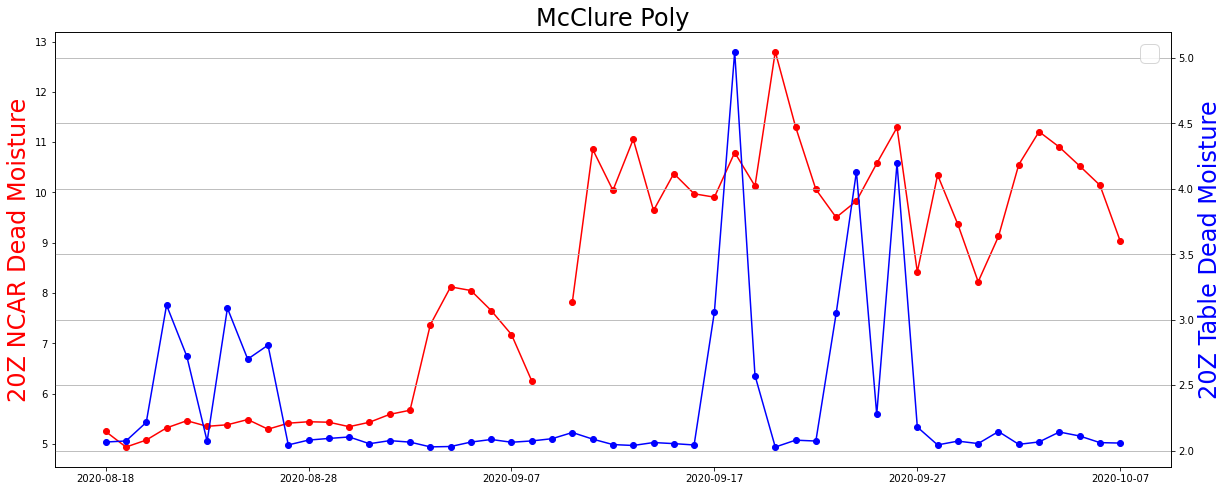

            NCAR Dead  Table Dead
NCAR Dead    1.000000    0.121002
Table Dead   0.121002    1.000000


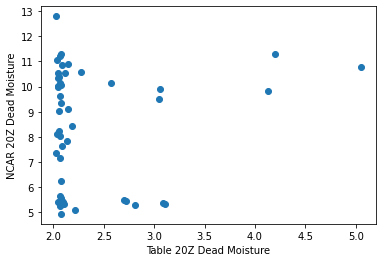

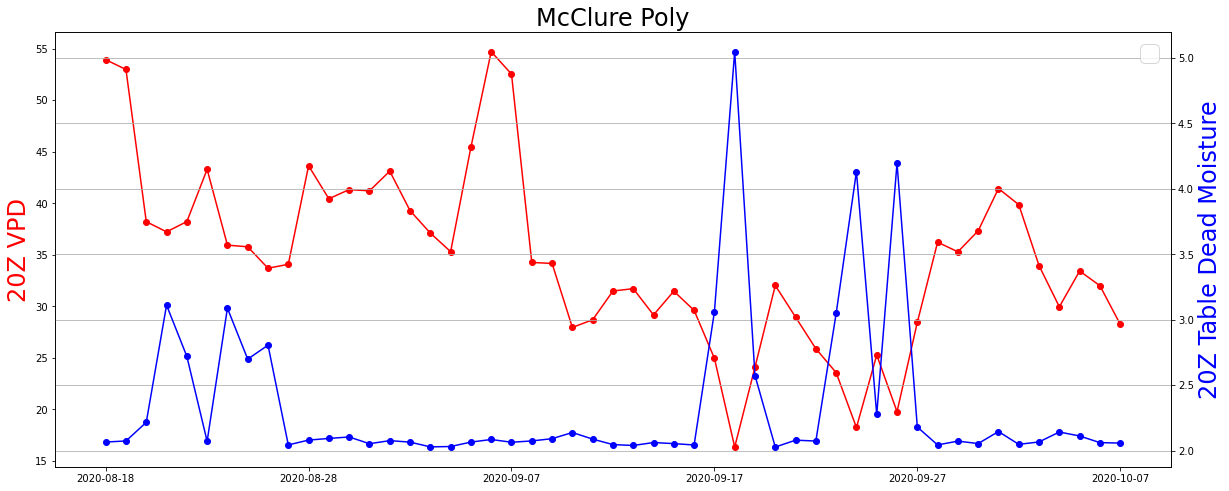

                 VPD  Table Dead
VPD         1.000000   -0.532232
Table Dead -0.532232    1.000000


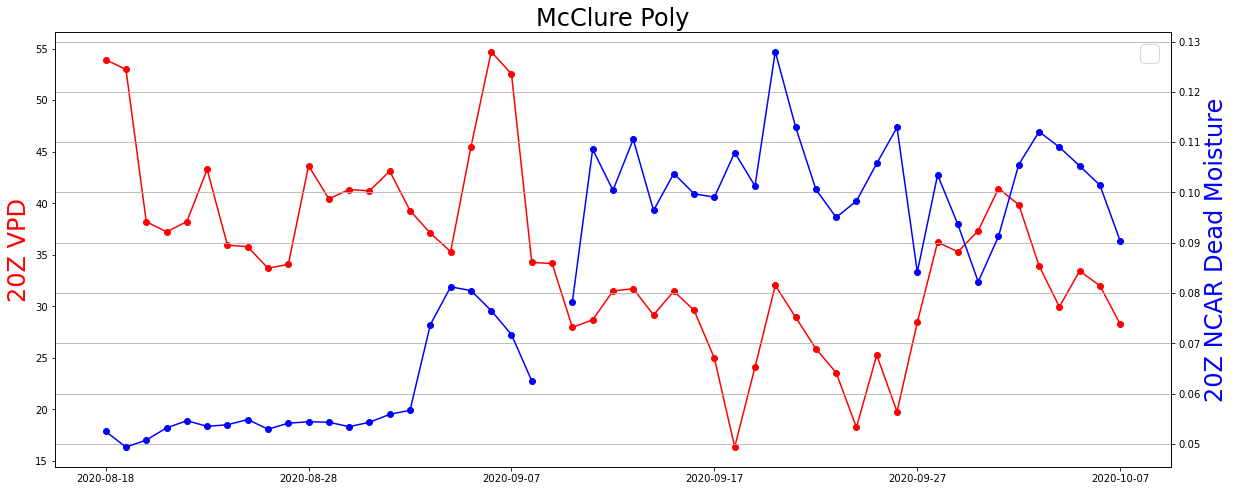

              VPD  NCAR Dead
VPD        1.0000    -0.6182
NCAR Dead -0.6182     1.0000


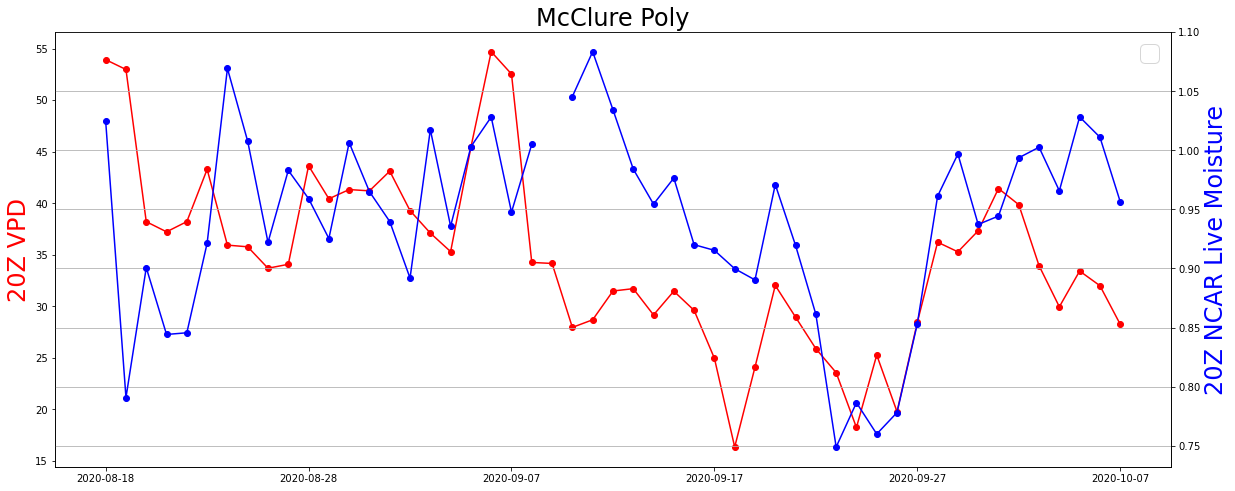

                VPD  NCAR Live
VPD        1.000000   0.316146
NCAR Live  0.316146   1.000000


In [114]:
# some twoline plots
plot_twoline(times, np.stack([df_mcclure['dead_moisture'].values[0:51]*100, df_moisture_mcclure['dead_moisture_table'].values]),\
             'McClure Poly',\
            [], ['20Z NCAR Dead Moisture', '20Z Table Dead Moisture'], 1)
print(pd.DataFrame({'NCAR Dead':df_mcclure['dead_moisture'].values[0:51],\
                    'Table Dead':df_moisture_mcclure['dead_moisture_table'].values}).corr())

plt.scatter(df_moisture_mcclure['dead_moisture_table'].values,df_mcclure['dead_moisture'].values[0:51]*100)
plt.ylabel('NCAR 20Z Dead Moisture')
plt.xlabel('Table 20Z Dead Moisture')
plt.show()

plot_twoline(times, np.stack([df_moisture_mcclure['vpd'], df_moisture_mcclure['dead_moisture_table'].values]),\
             'McClure Poly',\
            [], ['20Z VPD', '20Z Table Dead Moisture'], 1)
print(pd.DataFrame({'VPD':df_moisture_mcclure['vpd'],\
                    'Table Dead':df_moisture_mcclure['dead_moisture_table'].values}).corr())

plot_twoline(times, np.stack([df_moisture_mcclure['vpd'], df_mcclure['dead_moisture'].values[0:51]]),\
             'McClure Poly',\
            [], ['20Z VPD', '20Z NCAR Dead Moisture'], 1)
print(pd.DataFrame({'VPD':df_moisture_mcclure['vpd'],\
                    'NCAR Dead':df_mcclure['dead_moisture'].values[0:51]}).corr())

plot_twoline(times, np.stack([df_moisture_mcclure['vpd'], df_mcclure['living moisture'].values[0:51]]),\
             'McClure Poly',\
            [], ['20Z VPD', '20Z NCAR Live Moisture'], 1)
print(pd.DataFrame({'VPD':df_moisture_mcclure['vpd'],\
                    'NCAR Live':df_mcclure['living moisture'].values[0:51]}).corr())

In [79]:
#now do some plots with the fuels there too
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_igbp_mcclure = df_igbp_mcclure.drop(columns='Unnamed: 0')
df_igbp_mcclure= df_igbp_mcclure.iloc[0:51,:]
df_mcclure_simple = pd.DataFrame({'time':times,\
                                  'wet': df_igbp_mcclure['% water'].values+df_igbp_mcclure['% permanent wetlands'].values,\
                                 'forest':df_igbp_mcclure['% evergreen needleleaf forest'].values+\
                                  df_igbp_mcclure['% evergreen broadleaf forest'].values+\
                                 df_igbp_mcclure['% deciduous needleleaf forest'].values+\
                                  df_igbp_mcclure['% deciduous broadleaf forest'].values+\
                                  df_igbp_mcclure['% mixed forests'].values,\
                                 'shrub': df_igbp_mcclure['% closed shrubland'].values+\
                                  df_igbp_mcclure['% open shrublands'].values,\
                                 'savanna': df_igbp_mcclure['% woody savannas'].values+\
                                  df_igbp_mcclure['% savannas'].values,\
                                 'grass':df_igbp_mcclure['% grasslands'].values})



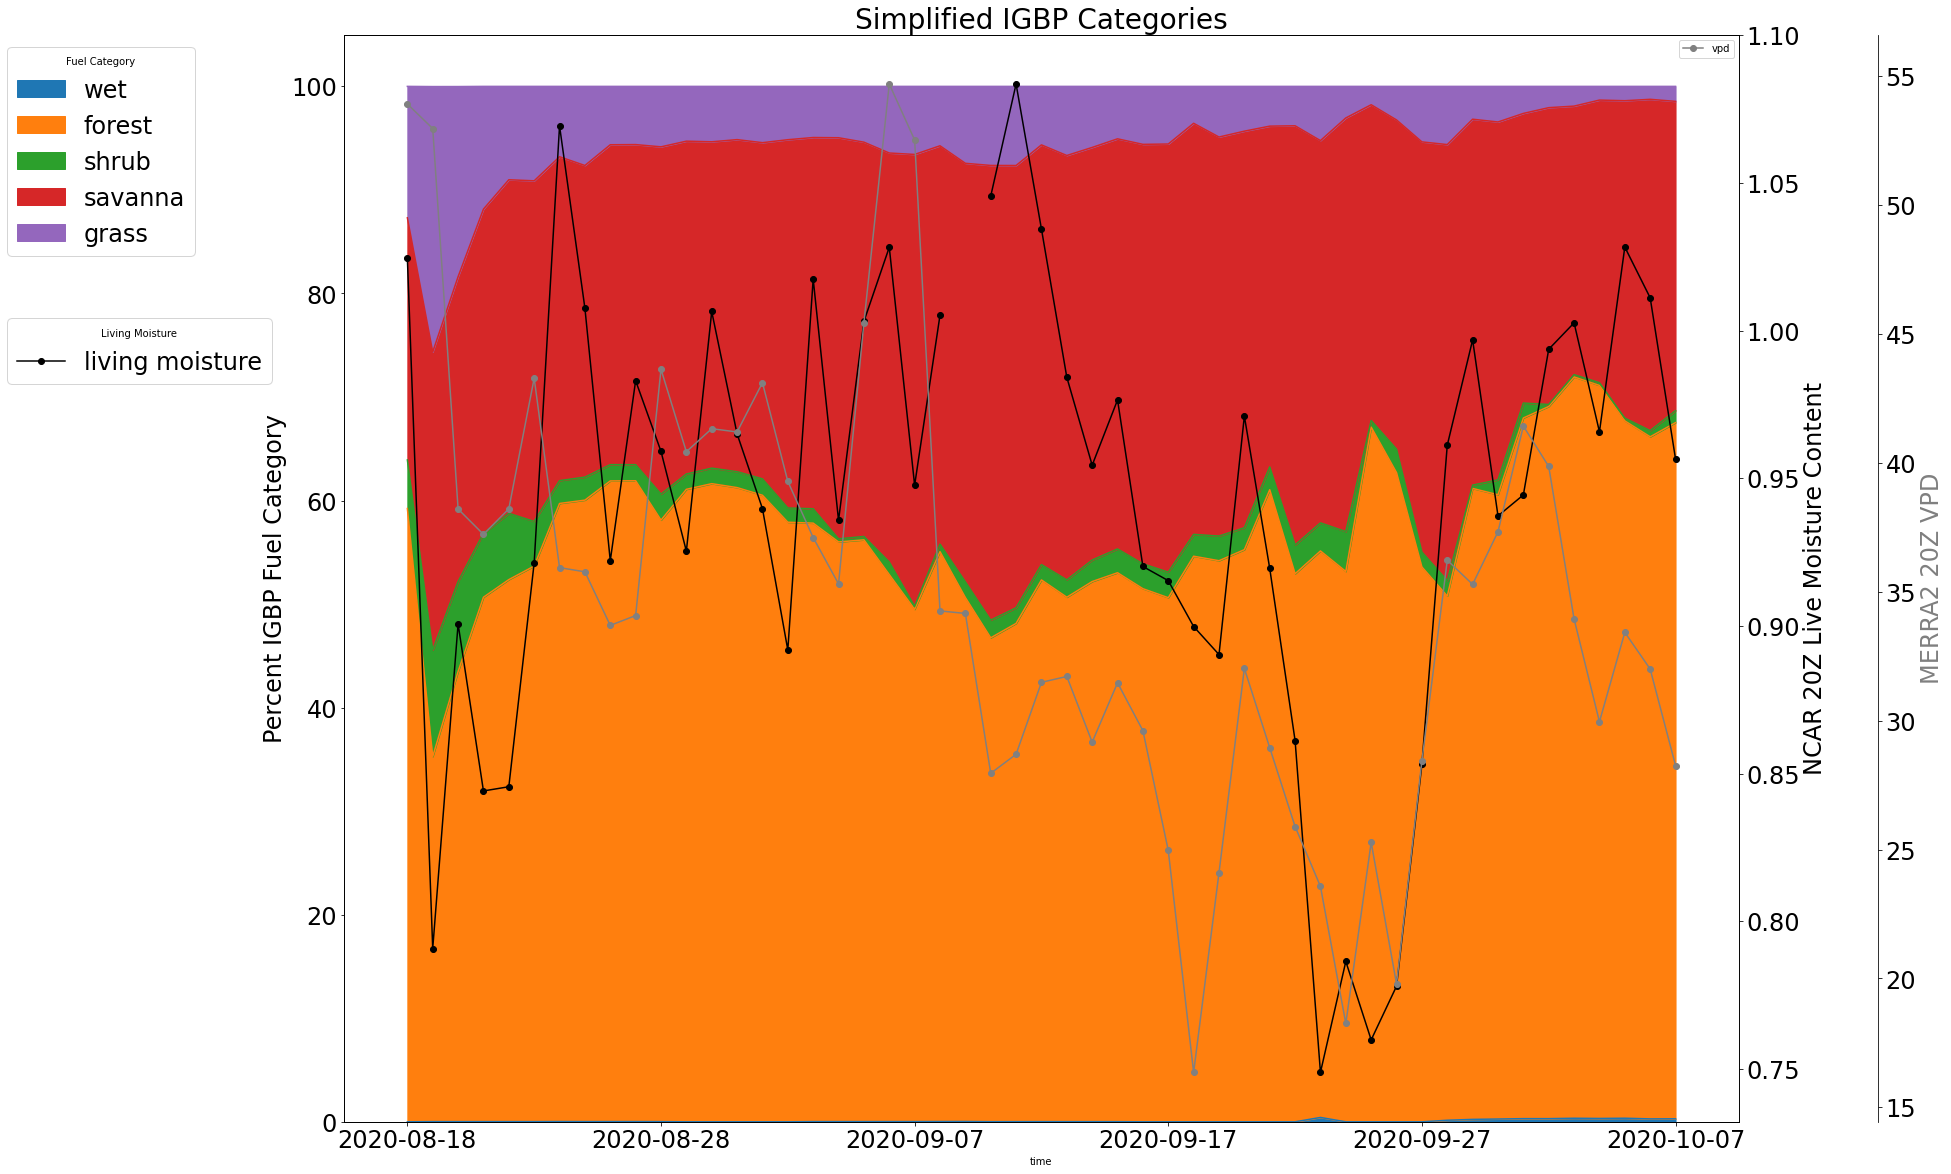

              live     % wet  % forest   % shrub   % grass
live      1.000000  0.084864  0.187514 -0.440315 -0.163460
% wet     0.084864  1.000000  0.544165 -0.301723 -0.384628
% forest  0.187514  0.544165  1.000000 -0.615896 -0.729146
% shrub  -0.440315 -0.301723 -0.615896  1.000000  0.860120
% grass  -0.163460 -0.384628 -0.729146  0.860120  1.000000


In [83]:
fig,ax=plt.subplots(figsize=(25,20))
df_mcclure_simple.plot.area(x='time',stacked='True', ax=ax, fontsize=24)
plt.legend(title='Fuel Category', bbox_to_anchor=(-.25, 1), loc='upper left', fontsize=24)
plt.ylabel('Percent IGBP Fuel Category', fontsize=24)

ax2=ax.twinx()
df_mcclure.iloc[0:51,:].plot(x='time', y='living moisture', ax=ax2, fontsize=24, color='k', marker='o')
#plt.plot(df_mcclure_simple['time'].values, .8*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
#plt.plot(df_mcclure_simple['time'].values, 1*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
#plt.plot(df_mcclure_simple['time'].values, 1.2*np.ones(len(df_mcclure_simple['time'].values)), 'w--')

plt.ylabel('NCAR 20Z Live Moisture Content', fontsize=24)

plt.legend(title='Living Moisture', bbox_to_anchor=(-.25, .75), loc='upper left', fontsize=24)

ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_moisture_mcclure.plot(x='time', y='vpd', ax=ax3, fontsize=24, color='gray', marker='o')
plt.ylabel('MERRA2 20Z VPD', fontsize=24,color='gray')



plt.title('Simplified IGBP Categories', fontsize=28)
plt.show()
print(pd.DataFrame({'live': df_mcclure['living moisture'].values[0:51], '% wet': df_mcclure_simple['wet'].values[0:51], '% forest': df_mcclure_simple['forest'].values[0:51]\
                   , '% shrub': df_mcclure_simple['shrub'].values[0:51], '% forest': df_mcclure_simple['forest'].values[0:51],'% grass': df_mcclure_simple['grass'].values[0:51]}).corr())


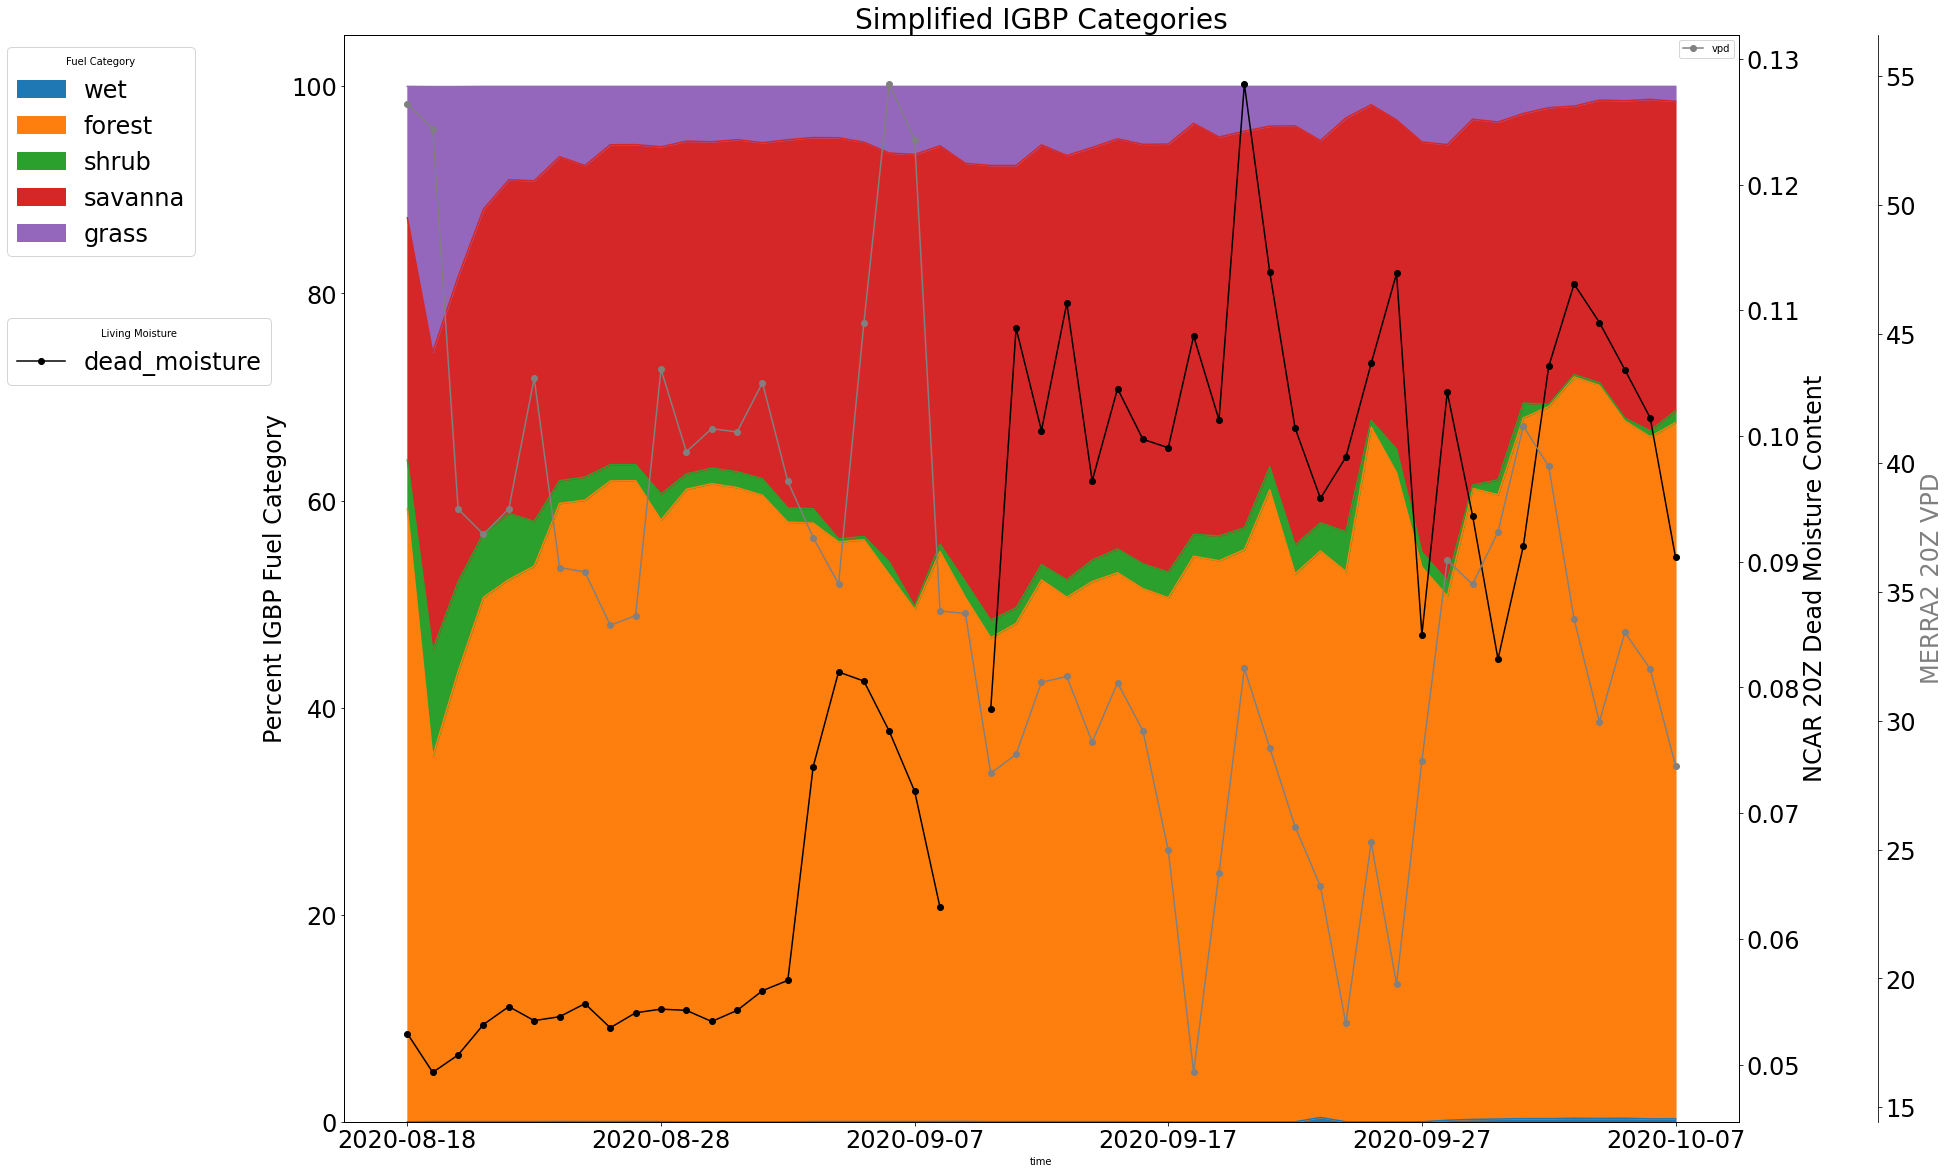

              dead     % wet  % forest   % shrub   % grass
dead      1.000000  0.338371  0.193530 -0.412273 -0.553260
% wet     0.338371  1.000000  0.544165 -0.301723 -0.384628
% forest  0.193530  0.544165  1.000000 -0.615896 -0.729146
% shrub  -0.412273 -0.301723 -0.615896  1.000000  0.860120
% grass  -0.553260 -0.384628 -0.729146  0.860120  1.000000


In [87]:
fig,ax=plt.subplots(figsize=(25,20))
df_mcclure_simple.plot.area(x='time',stacked='True', ax=ax, fontsize=24)
plt.legend(title='Fuel Category', bbox_to_anchor=(-.25, 1), loc='upper left', fontsize=24)
plt.ylabel('Percent IGBP Fuel Category', fontsize=24)

ax2=ax.twinx()
df_mcclure.iloc[0:51,:].plot(x='time', y='dead_moisture', ax=ax2, fontsize=24, color='k', marker='o')
#plt.plot(df_mcclure_simple['time'].values, .8*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
#plt.plot(df_mcclure_simple['time'].values, 1*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
#plt.plot(df_mcclure_simple['time'].values, 1.2*np.ones(len(df_mcclure_simple['time'].values)), 'w--')

plt.ylabel('NCAR 20Z Dead Moisture Content', fontsize=24)

plt.legend(title='Living Moisture', bbox_to_anchor=(-.25, .75), loc='upper left', fontsize=24)

ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_moisture_mcclure.plot(x='time', y='vpd', ax=ax3, fontsize=24, color='gray', marker='o')
plt.ylabel('MERRA2 20Z VPD', fontsize=24,color='gray')



plt.title('Simplified IGBP Categories', fontsize=28)
plt.show()
print(pd.DataFrame({'dead': df_mcclure['dead_moisture'].values[0:51], '% wet': df_mcclure_simple['wet'].values[0:51], '% forest': df_mcclure_simple['forest'].values[0:51]\
                   , '% shrub': df_mcclure_simple['shrub'].values[0:51], '% forest': df_mcclure_simple['forest'].values[0:51],'% grass': df_mcclure_simple['grass'].values[0:51]}).corr())


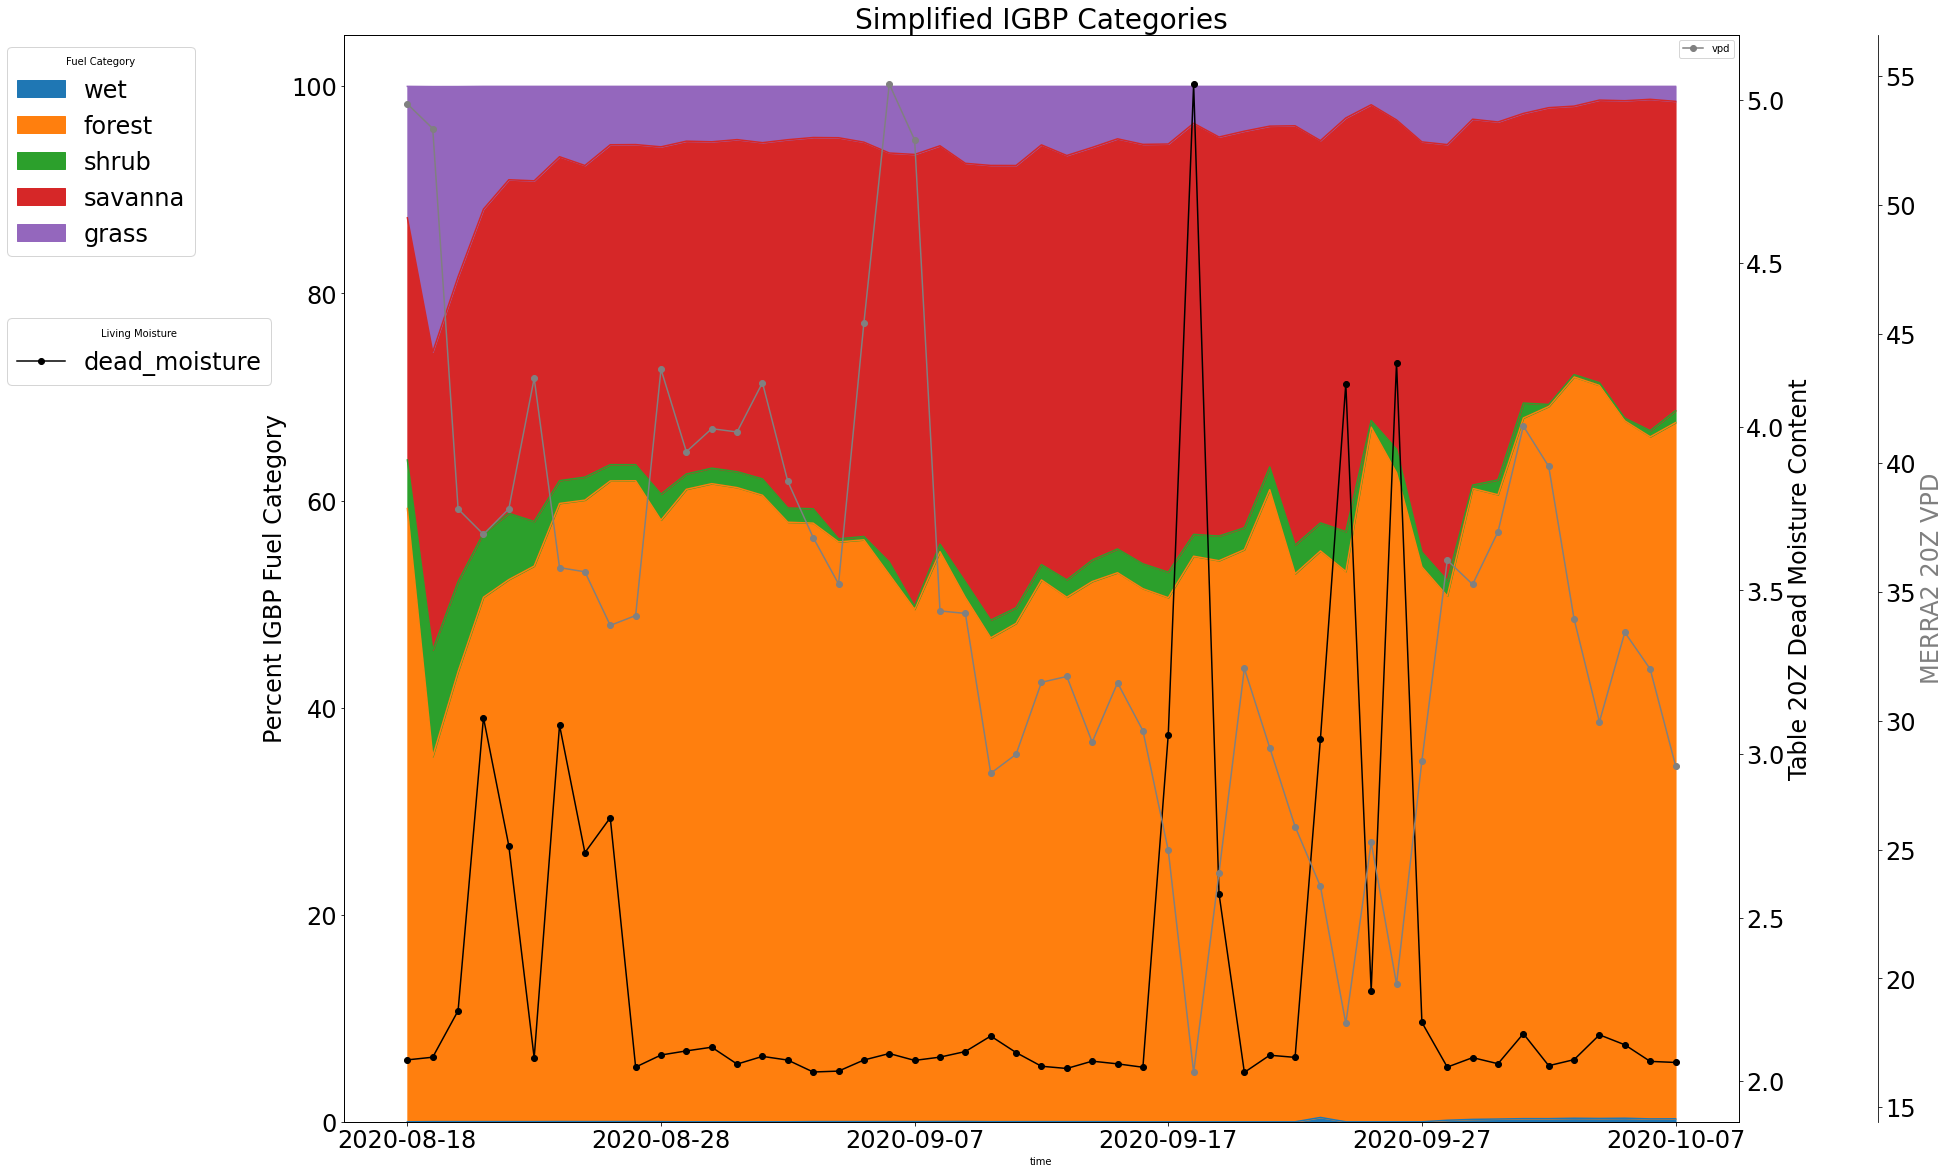

              dead     % wet  % forest   % shrub   % grass
dead      1.000000 -0.129260 -0.052255  0.188780 -0.067456
% wet    -0.129260  1.000000  0.544165 -0.301723 -0.384628
% forest -0.052255  0.544165  1.000000 -0.615896 -0.729146
% shrub   0.188780 -0.301723 -0.615896  1.000000  0.860120
% grass  -0.067456 -0.384628 -0.729146  0.860120  1.000000


In [89]:
fig,ax=plt.subplots(figsize=(25,20))
df_mcclure_simple.plot.area(x='time',stacked='True', ax=ax, fontsize=24)
plt.legend(title='Fuel Category', bbox_to_anchor=(-.25, 1), loc='upper left', fontsize=24)
plt.ylabel('Percent IGBP Fuel Category', fontsize=24)

ax2=ax.twinx()
df_moisture_mcclure.plot(x='time', y='dead_moisture', ax=ax2, fontsize=24, color='k', marker='o')
#plt.plot(df_mcclure_simple['time'].values, .8*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
#plt.plot(df_mcclure_simple['time'].values, 1*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
#plt.plot(df_mcclure_simple['time'].values, 1.2*np.ones(len(df_mcclure_simple['time'].values)), 'w--')

plt.ylabel('Table 20Z Dead Moisture Content', fontsize=24)

plt.legend(title='Living Moisture', bbox_to_anchor=(-.25, .75), loc='upper left', fontsize=24)

ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_moisture_mcclure.plot(x='time', y='vpd', ax=ax3, fontsize=24, color='gray', marker='o')
plt.ylabel('MERRA2 20Z VPD', fontsize=24,color='gray')



plt.title('Simplified IGBP Categories', fontsize=28)
plt.show()
print(pd.DataFrame({'dead': df_moisture_mcclure['dead_moisture'].values[0:51], '% wet': df_mcclure_simple['wet'].values[0:51], '% forest': df_mcclure_simple['forest'].values[0:51]\
                   , '% shrub': df_mcclure_simple['shrub'].values[0:51], '% forest': df_mcclure_simple['forest'].values[0:51],'% grass': df_mcclure_simple['grass'].values[0:51]}).corr())


## Correlogram

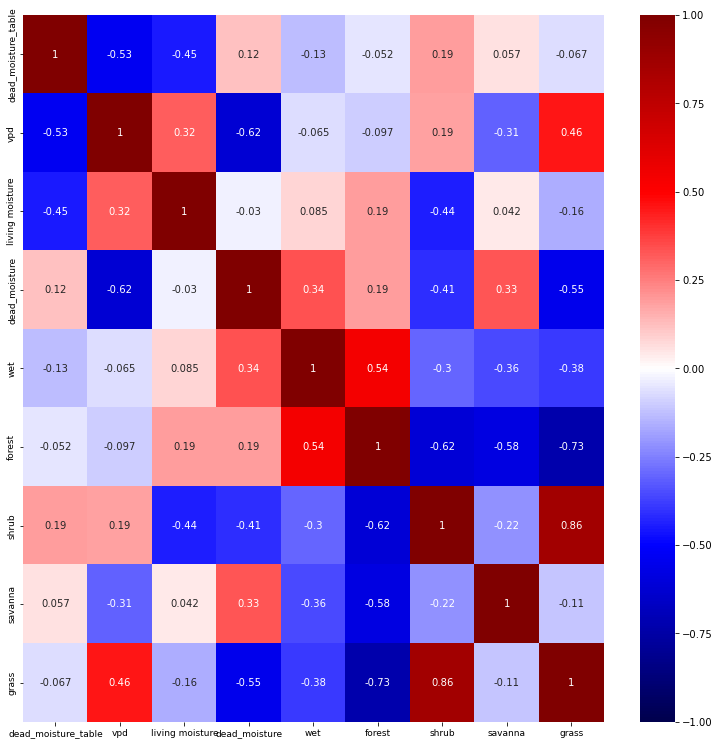

In [121]:
df_mcclure_combined = pd.concat([df_moisture_mcclure,df_mcclure[['living moisture', 'dead_moisture']].iloc[0:51,:],\
                                 df_mcclure_simple[['wet', 'forest', 'shrub','savanna', 'grass']].iloc[0:51,:]], axis=1)


corrMatrix = df_mcclure_combined.drop(columns='Unnamed: 0').corr()
fig,ax=plt.subplots(figsize=(13,13))
sns.heatmap(corrMatrix, annot=True, vmin=-1, vmax=1,cmap='seismic')
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)
plt.show()

## Helper Functions

In [12]:
def calculate_grid_cell_corners(LAT, LON):
    #we will assume the very edges of the polygons don't touch the boundary of the domain
    lat_corners = (LAT[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LAT[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    lon_corners = (LON[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LON[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    return lat_corners, lon_corners

In [13]:
# this function calculates the overlap between the given shape (fire_shape) and given grid (LAT, LON). 
# buff_search is the buffer for finding overlaps, =1 for everything except NCAR Fuel = 0.05
#grid type should be 'rectilinear' or 'curvilinear'
#LAT and LON should be 2D

def calculate_overlaps(lat, lon, lat_corners, lon_corners, fire_shape, grid_type, buff_search):
    overlaps = np.zeros(lat.shape)
    # buffer the fire shape so it has a non zero area
    if fire_shape.area ==0:
        fire_shape = fire_shape.buffer(0.01)
    fire_shape = fire_shape.buffer(0)
    #print(fire_shape.area)
    #buffer again by 1 degree so we can get the lat start and lat stop
    fire_shape_buff = fire_shape.buffer(buff_search)
    # get the bounds of the buffered polygon
    w,s,e,n = fire_shape_buff.bounds
    print(w,s,e,n)
    if grid_type =='rectilinear':    
        lat_start = np.unique(np.argmin(np.abs(lat-s), axis=0))[0]
        lat_stop = np.unique(np.argmin(np.abs(lat-n), axis=0))[0]
        lon_start = np.unique(np.argmin(np.abs(lon-w), axis=1))[0]
        lon_stop = np.unique(np.argmin(np.abs(lon-e), axis=1))[0]
        #print(lat_start, lat_stop, lon_start, lon_stop)
    elif grid_type=='curvilinear':
        lon_start, lon_stop, lat_start, lat_stop =  bbox2ij(lon, lat, [w, e, s, n])
        
    print(lon_start, lon_stop, lat_start, lat_stop)
    # find the intersection between the first day's polygon and the  grid
    for ii in range(lat_start, lat_stop):
        for jj in range(lon_start, lon_stop):
            #print(lat[ii,jj], lon[ii,jj])
            poly_cell = Polygon([(lon_corners[ii, jj-1],lat_corners[ii, jj-1]),\
                                 (lon_corners[ii, jj],lat_corners[ii, jj]),\
                                 (lon_corners[ii-1, jj],lat_corners[ii-1, jj-1]),\
                                 (lon_corners[ii-1, jj-1], lat_corners[ii-1, jj-1])])
            #THIS SHOWS THE CELLS WE CHECK FOR OVERLAPS
            #fig = plt.figure(figsize=(15,10))
            #ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
            #gpd.GeoSeries(poly_cell).plot(ax=ax)
            #gpd.GeoSeries(fire_shape).plot(ax=ax, color='r', alpha=0.5)
            #plt.xticks()
            #plt.yticks()
            #plt.show()
            overlap_cell = fire_shape.intersection(poly_cell)
            #print(overlap_cell)
            #overlaps are the fraction of the POLYGON in each grid cell
            overlaps[ii,jj] = overlap_cell.area/fire_shape.area
    
    return overlaps

In [14]:
# this function extracts a feature hourly over the polygon for the day
#IN: feat_grid, the 3d grid of the feature. overlaps: the 2d grid of the overlaps. 3d grid needs time as 1st dimension
#OUT: hourly_vec, the hourly time series of the feature over the day for the polygon

def feature_hourly(feat_grid, overlaps): 
    overlaps_stacked = np.repeat(overlaps[:, :, np.newaxis], 24, axis=2) #stack the 2d overlaps into a 3d grid
    overlaps_swapped = np.swapaxes(np.swapaxes(overlaps_stacked, 0,2), 1,2) #make the same shape as the feature grid

    hourly_grid = np.multiply(overlaps_swapped, feat_grid)
    hourly_vec = np.nansum(np.nansum(hourly_grid, axis=1), axis=1)
    
    return hourly_vec

In [57]:
#plots two lines, on one or on the same axis
# IN: datax, x axis vector (time)
# IN: datay, 2*n vector of the data
# IN: linelabels, string vector of the labels of each line, to go in the legend
# IN: axis labels, labels of the axis
# IN: title, string for title of figire
# IN: twoaxis, if 1 plot data on two separate axes, else plot on the same axis
# OUT: a graph
def plot_twoline(datax, datay, title, linelabels, axislabels, twoaxis):
    fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
    
    if twoaxis==1:
        ax.plot(datax, datay[0,:], 'ro-') # plot the first line
        ax.set_ylabel(axislabels[0], fontsize=24, color='red') 
        ax2=ax.twinx()
        ax2.plot(datax, datay[1,:], 'bo-') #plot the second line
        ax2.set_ylabel(axislabels[1], fontsize=24, color='blue')
        
    else:
        ax.plot(datax, datay[0,:], 'ro-') # plot the first line
        ax.plot(datax, datay[1,:], 'bo-') # plot the second line
        ax.set_ylabel(axislabels, fontsize=24) 
    
        
    plt.legend(linelabels,fontsize=24)
    plt.title(title,fontsize=24)
    plt.xticks(np.arange(0,len(datax),10))
    plt.grid()
    plt.show()



In [16]:
#finds the most common value of the array (the mode)
#IN the array
#OUT the mode of the array
def find_mode(arr):
    vals,counts = np.unique(arr, return_counts=True)
    index = np.argmax(counts)
    return vals[index]


In [17]:
#fnction is from here: https://gis.stackexchange.com/questions/71630/subsetting-a-curvilinear-netcdf-file-roms-model-output-using-a-lon-lat-boundin
def bbox2ij(lon,lat,bbox):
    bbox=np.array(bbox)
    mypath=np.array([bbox[[0,1,1,0]],bbox[[2,2,3,3]]]).T
    p = path.Path(mypath)
    points = np.vstack((lon.flatten(),lat.flatten())).T
    n,m = np.shape(lon)
    inside = p.contains_points(points).reshape((n,m))
    ii,jj = np.meshgrid(range(m),range(n)) #ii is the columns, jj is the rows
    return min(ii[inside]),max(ii[inside]),min(jj[inside]),max(jj[inside])

In [18]:
earth_SA = 5e14; #surface area of earth m2


def area_per_grid_cell(lats, lons, dlat, dlon):
    r_earth = 6.371e6; #radius of earth in m
    area_per_box = np.zeros((len(lats), len(lons)));
    for ii in range(len(lons)): #loop over the lons/x positions
        for jj in range(len(lats)): # loop over the lats/y positions
            top_lat = lats[jj]+(dlat/2); #upper bounds of the box, centered at (lon_merra(ii),lat_merra(jj)) 
            bottom_lat = lats[jj]-(dlat/2); # lower bounds of the box, centered at (lon_merra(ii),lat_merra(jj)) 
            box_height = dlat*r_earth*(math.pi/180); # box heights in m, constant because latiude lines are parallel
            top_width = (r_earth*dlon*math.pi*np.cos(math.radians(top_lat)))/180;
            bottom_width = (r_earth*dlon*math.pi*np.cos(math.radians(bottom_lat)))/180;
            area_per_box[jj,ii] = (bottom_width + top_width)*box_height/2; # trapezoid approximation, simplifies to triangles at the poles
    return(area_per_box)


In [19]:
#IN: an nc dataset from GOES
#OUT LAT/LON in the right projection
def project_abi(data_cod): #grid edges
    # grab the constants needed to do the projection from GOES grid to lat/lon
    Req = data_cod.variables['goes_imager_projection'].semi_major_axis
    Rpol = data_cod.variables['goes_imager_projection'].semi_minor_axis
    lambda_0 = data_cod.variables['goes_imager_projection'].longitude_of_projection_origin
    lambda_0 = lambda_0*math.pi/180
    Hsat = data_cod.variables['goes_imager_projection'].perspective_point_height
    H = Hsat+Req
    
    # projection from GOES grid to lat/lon, following https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    lat_rad_1d = data_cod['x'][:]
    lon_rad_1d = data_cod['y'][:]
    
    [X, Y] = np.meshgrid(lat_rad_1d, lon_rad_1d) # lon is x, lat is y, uses 'xy' indexing by default

    # sin and cos of x and y
    sinx = np.sin(X)
    sinx2 = sinx**2
    siny = np.sin(Y)
    siny2 = siny**2
    cosx = np.cos(X)
    cosx2 = cosx**2
    cosy = np.cos(Y)
    cosy2 = cosy**2

    a = np.power(np.sin(X),2.0) + (np.power(np.cos(X),2.0)*(np.power(np.cos(Y),2.0)+(((Req*Req)/(Rpol*Rpol))*np.power(np.sin(Y),2.0))))
    b = -2.0*H*np.cos(X)*np.cos(Y)
    c = (H**2.0)-(Req**2.0)

    # calculate rs
    rs = (-b - np.sqrt((b**2)-(4*a*c)))/2*a

    # calculate sx, sy, sz
    sx = rs*cosx*cosy
    sy = -rs*sinx
    sz = rs*cosx*siny
        
    # calculate lat and lon
    test = (Req**2/Rpol**2)*(sz/np.sqrt(((H-sx)**2)+(sy**2)))
    lat = np.arctan(test) 
    lon = lambda_0 - np.arctan(sy/(H-sx)) # in radians

    lat_deg = lat*180/math.pi
    lon_deg = lon*180/math.pi

    return lat_deg, lon_deg